In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import re

%matplotlib inline  
pd.set_option('display.max_columns', None)

In [2]:
mem = pd.read_csv('../data/NSS_GreatCare_Members.csv')
adm = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv', low_memory = False)
hosp = pd.read_csv('../data/hosp_npi.csv')
att = pd.read_csv('../data/hosp_doc_npi.csv')

# Variables and DFs
mem - members dataset given <br>
adm - admissions dataset given<br>
pcp - primary care providers dataset given<br>
hosp - Tim's hospital names dataset<br>

one - df of all admissions cleaned<br>
one_top - df of readmissions within 30 days<br>
adm_count - count of admissions<br>
read_count - count of readmissions within 30 days<br>
read_rate - readmission rate (read_count/adm_count) *100<br>

read_count_patients - readmissions grouped by patient and counted<br>
read_count_patients_high - where patients were readmitted in 30 days over _ times<br>

read_count_hospital - readmissions grouped by hospital and counted<br>
read_count_hospital_high - where hospitals had over _ 30 day readmissions <br>
read_count_hospital_high2 - previous cleaned<br>

ad_count_hospital - admissions grouped by hospital and counted<br>
ad_count_hospital_high - where hospitals had over _ admissions <br>
ad_count_hospital_high2 - previous cleaned<br>

read_count_attendant - readmissions grouped by attendant and counted<br>
read_count_attendant_high - where readmissions by an attendant were over _ times<br>
read_count_month - readmissions grouped by month and counted <br>

combo - merge ad_count_hospital_high2 and read_count_hospital_high2 - to find rate of readmission<br>
combo3 - add where readmissions were within 0 days<br>
combo4 - cleaned for graphing<br>

hundy - look into hospital with 100 of readmissions being same day<br>

In [3]:
#set datetime
adm['Encounter Start Date'] = pd.to_datetime(adm['Encounter Start Date'], format='%Y-%m-%d')
adm['Encounter End Date'] = pd.to_datetime(adm['Encounter End Date'], format='%Y-%m-%d')
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')

# MVP 1 
What is our 30-day all cause readmission rate across hospitals our members are admitted to?

In [4]:
#clean and transform dfs
#order by patient then start date
one = adm.sort_values(['Patient ID',"Encounter Start Date", "Encounter End Date"], ascending = (False, True, True))
#To calculate the days between admissions:
#shift previous end date to next row correct format and calculate
one['Previous End Date'] = (one.groupby('Patient ID')['Encounter End Date'].shift(1))
one['Previous End Date'] = pd.to_datetime(one['Previous End Date'], format='%Y-%m-%d')
one['Days Since Last Visit'] = one['Encounter Start Date'] - one['Previous End Date']

adm_count = len(one)


In [5]:
#filter for readmission and within 30 days
one_top = one
one_top = one_top[one_top['Days Since Last Visit'].notnull()]
one_top = one_top[one_top['Days Since Last Visit'] <= '30 days']
one_top = one_top[one_top['Days Since Last Visit'] >= '0 days']

#read_count is the number of patients who were readmitted within 30 days of their prior adm
read_count = len(one_top)

In [6]:
#find the readmission rate1
read_rate = round(read_count/adm_count *100,2)
read_rate

11.31

# Visualize it


In [7]:
# new variables
one_top['year'] = pd.DatetimeIndex(one_top['Previous End Date']).year
one_top['month'] = pd.DatetimeIndex(one_top['Previous End Date']).month

HISTOGRAM

In [8]:
#filter for number of readmissions per patient
read_count_patient = one_top.groupby(['Patient ID'], as_index=False).count()
read_count_patient = read_count_patient.sort_values(['Patient ID'], ascending = (False))
read_count_patient_high = read_count_patient[read_count_patient['Encounter ID'] >= 3]


In [9]:
#filter for number of readmissions per Hospital
read_count_hospital = one_top.groupby(['Facility Provider NPI'], as_index=False).count()
read_count_hospital = read_count_hospital.sort_values(['Patient ID'], ascending = (False))
read_count_hospital_high = read_count_hospital[read_count_hospital['Encounter ID'] >= 0]
read_count_hospital_high2= read_count_hospital_high[['Facility Provider NPI','Encounter ID']]


In [10]:
#filter for number of readmissions per Hospital
ad_count_hospital = one.groupby(['Facility Provider NPI'], as_index=False).count()
ad_count_hospital = ad_count_hospital.sort_values(['Patient ID'], ascending = (False))
ad_count_hospital_high = ad_count_hospital[ad_count_hospital['Encounter ID'] >= 0]
ad_count_hospital_high2= ad_count_hospital_high[['Facility Provider NPI','Encounter ID']]


In [11]:
#filter for number of readmissions per Attendant 
read_count_attendant = one_top.groupby(['Attending Provider NPI'], as_index=False).count()
read_count_attendant = read_count_attendant.sort_values(['Patient ID'], ascending = (False))
read_count_attendant_high = read_count_attendant[read_count_attendant['Encounter ID'] >= 2]

In [12]:
#filter for number of readmissions per month
read_count_month = one_top.groupby(['year','month'], as_index=False).count()
read_count_month = read_count_month.sort_values(['year','month','Patient ID'], ascending = (True,True,False))
read_count_month_high = read_count_month[read_count_month['Encounter ID'] >= 0]

In [13]:
combo = read_count_hospital_high2.merge(ad_count_hospital_high2, how = 'left', on = 'Facility Provider NPI')
combo['rate']= combo['Encounter ID_x']/  combo['Encounter ID_y'] *100
combo = combo.sort_values(['rate'], ascending = (False))
combo = combo[combo['Encounter ID_y'] >= 10]

combo3 = one_top[one_top['Days Since Last Visit'] == '0 days']
combo3 = combo3.groupby(['Facility Provider NPI'], as_index=False).count()
combo3 = combo3.sort_values(['Encounter ID'], ascending = (False))
combo3 = combo3[['Facility Provider NPI', 'Patient ID']]
combo4 = combo.merge(combo3, how = 'left', on = 'Facility Provider NPI')
combo4 = combo4.sort_values(['Patient ID'], ascending = (False))
combo4['same day'] = combo4['Patient ID']/ combo4['Encounter ID_y']*100
combo4 = combo4[['Facility Provider NPI','rate', 'same day']]
combo4 = combo4.sort_values(['rate'], ascending = (True))
combo4['Facility Provider NPI'] = combo4['Facility Provider NPI'].astype(str).astype(int)
combo4 = combo4.merge(hosp, how = 'left', left_on = 'Facility Provider NPI', right_on = 'NPI')
combo4 = combo4[['Facility Provider NPI', 'rate','same day','Facility']]
combo4 = combo4[combo4['Facility Provider NPI'] != 0]
combo4 = combo4[combo4['rate'] >= 13.5]
combo4['Facility'] = combo4['Facility'].astype(str)

combo4

,Facility Provider NPI,rate,same day,Facility
16,1811080526,13.636364,NaN,CHILDREN'S HOSPITAL OF ORANGE COUNTY
18,1023065729,16.666667,NaN,WEST HILLS HOSPITAL
19,1770532608,18.181818,NaN,SUTTER VALLEY HOSPITALS
20,1174667158,19.047619,19.047619,DIGNITY HEALTH
21,1710065933,22.018349,0.917431,RADY CHILDREN'S HOSPITAL - SAN DIEGO
22,1467459776,25.000000,NaN,TORRANCE MEMORIAL MEDICAL CENTER
23,1639172372,25.000000,NaN,CEDARS-SINAI MEDICAL CENTER
24,1336328244,30.000000,NaN,"PRIME HEALTHCARE CENTINELA, LLC"
25,1952546616,60.000000,NaN,UNIVERSITY OF SOUTHERN CALIFORNIA
26,1265814065,90.909091,81.818182,"CALIFORNIA REHABILITATION INSTITUTE, LLC"


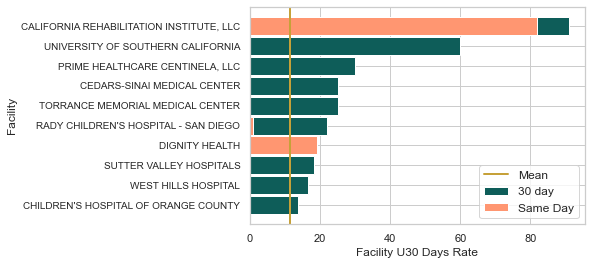

In [47]:

rc={'figure.figsize':(15,8)}
fig, ax = plt.subplots()

ax.barh(width = combo4['rate'], y = combo4['Facility'], height = .9, label='30 day',  color=['#0e5d59'])
ax.barh(width = combo4['same day'], y = combo4['Facility'],height = .9, label='Same Day',color=['#ff9671'])

ax.set_ylabel('Facility', fontsize = '12')
ax.set_xlabel('Facility U30 Days Rate', fontsize = '12')
#ax.set_title('Readmission by Hospital', fontsize = '20')
ax.tick_params(axis='y', labelsize=10)
plt.axvline(11.3, color = '#c6a139', lw = 2, label = 'Mean')
ax.legend(fontsize = '12', loc = 'lower right')

#plt.tight_layout(rect)
plt.savefig('../imgs/stacked', bbox_inches = 'tight',transparent = True)

In [15]:
#drill down 
hundy = one_top[one_top['Facility Provider NPI'] == '1265814065']
hundy = hundy.sort_values(['Attending Provider NPI'], ascending = (True))
#hundy2 = hundy.merge(att, how = 'left', left_on = 'Attending Provider NPI', right_on = 'NPI')
#hundy = one_top[one_top['Attending Provider NPI'] == '1.396006e+09']
hundyatt = hundy.groupby(['Attending Provider NPI'], as_index=False).count()
#hundy_count = len(hundy)
hundy

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Previous End Date,Days Since Last Visit,year,month
1206,HIA|DS1|2049|DS1|NPI|1265814065|1,DS1|2049,DS1|1,DS1|5047W,DS1|NPI|1265814065,DS1|NPI|1104960517,1.104961e+09,1265814065,2012-07-09,2012-07-17,0,0,3.0,4,1,21.0,NaN,NaN,C79.31,Secondary malignant neoplasm of brain,0,30294.60,172.27,2012-07-09,0 days,2012,7
688,HIA|DS1|15935|DS1|NPI|1265814065|1,DS1|15935,DS1|1,DS1|5047W,DS1|NPI|1265814065,DS1|NPI|1104960517,1.104961e+09,1265814065,2016-02-01,2016-02-07,0,0,3.0,4,2,21.0,NaN,NaN,G35,Multiple sclerosis,0,22550.00,250.00,2016-02-01,0 days,2016,2
2835,HIA|DS1|35012|DS1|NPI|1265814065|1,DS1|35012,DS1|1,DS1|5047W,DS1|NPI|1265814065,DS1|NPI|1295094134,1.295094e+09,1265814065,2012-02-15,2012-02-23,0,0,3.0,4,1,61.0,NaN,NaN,S83.094A,"Other dislocation of right patella, initial en...",0,30150.00,250.00,2012-02-15,0 days,2012,2
4811,HIA|DS1|52751|DS1|NPI|1265814065|1,DS1|52751,DS1|1,DS1|5047Z,DS1|NPI|1265814065,DS1|NPI|1396005849,1.396006e+09,1265814065,2015-06-18,2015-07-01,0,0,3.0,1,1,22.0,NaN,NaN,S06.5X9A,Traumatic subdural hemorrhage with loss of con...,0,49400.00,0.00,2015-05-27,22 days,2015,5
671,HIA|DS1|15773|DS1|NPI|1265814065|1,DS1|15773,DS1|1,DS1|5047Y,DS1|NPI|1265814065,DS1|NPI|1396005849,1.396006e+09,1265814065,2013-12-10,2013-12-13,0,0,3.0,4,30,61.0,NaN,NaN,G61.0,Guillain-Barre syndrome,0,14950.00,250.00,2013-12-10,0 days,2013,12
2322,HIA|DS1|30393|DS1|NPI|1265814065|1,DS1|30393,DS1|1,DS1|5047X,DS1|NPI|1265814065,DS1|NPI|1407293913,1.407294e+09,1265814065,2015-07-28,2015-09-08,0,0,3.0,4,82,22.0,NaN,NaN,I61.8,Other nontraumatic intracerebral hemorrhage,0,161615.98,0.00,2015-07-28,0 days,2015,7
2918,HIA|DS1|3572|DS1|NPI|1265814065|1,DS1|3572,DS1|1,DS1|5047W,DS1|NPI|1265814065,DS1|NPI|1609081447,1.609081e+09,1265814065,2013-05-01,2013-05-07,0,0,3.0,4,1,21.0,NaN,NaN,I61.2,Nontraumatic intracerebral hemorrhage in hemis...,0,22691.75,115.00,2013-05-01,0 days,2013,5
754,HIA|DS1|16409|DS1|NPI|1265814065|1,DS1|16409,DS1|1,DS1|5047W,DS1|NPI|1265814065,DS1|NPI|1609081447,1.609081e+09,1265814065,2012-07-23,2012-07-24,1,0,3.0,4,2,21.0,NaN,NaN,I63.50,Cerebral infarction due to unspecified occlusi...,0,4300.76,0.00,2012-07-23,0 days,2012,7
755,HIA|DS1|16409|DS1|NPI|1265814065|2,DS1|16409,DS1|1,DS1|5047W,DS1|NPI|1265814065,DS1|NPI|1609081447,1.609081e+09,1265814065,2012-07-28,2012-08-04,0,0,3.0,4,1,21.0,NaN,NaN,I63.50,Cerebral infarction due to unspecified occlusi...,0,26600.00,0.00,2012-07-28,0 days,2012,7
2323,HIA|DS1|30393|DS1|NPI|1265814065|2,DS1|30393,DS1|1,DS1|5047X,DS1|NPI|1265814065,DS1|NPI|1790917086,1.790917e+09,1265814065,2015-09-14,2015-09-29,0,0,3.0,4,62,21.0,NaN,NaN,I61.8,Other nontraumatic intracerebral hemorrhage,0,57000.00,0.00,2015-09-14,0 days,2015,9


In [16]:
#drill down 
hundy3 = one_top[one_top['Facility Provider NPI'] == '1174667158']
hundy3 = hundy3.sort_values(['Attending Provider NPI'], ascending = (True))
#hundy4 = one_top[one_top['Attending Provider NPI'] == '1.396006e+09']
hundyatts = hundy.groupby(['Attending Provider NPI'], as_index=False).count()
#hundy_count = len(hundy)
hundy3

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Previous End Date,Days Since Last Visit,year,month
3506,HIA|DS1|40868|DS1|NPI|1174667158|1,DS1|40868,DS1|1,DS1|5047W,DS1|NPI|1174667158,DS1|NPI|1265435762,1.265436e+09,1174667158,2014-02-14,2014-02-21,0,0,3.0,4,6,NaN,NaN,NaN,F17.200,"Nicotine dependence, unspecified, uncomplicated",0,0.0,0.0,2014-02-14,0 days,2014,2
2906,HIA|DS1|35624|DS1|NPI|1174667158|1,DS1|35624,DS1|1,DS1|5047X,DS1|NPI|1174667158,DS1|NPI|1386732352,1.386732e+09,1174667158,2011-09-26,2011-11-01,0,0,3.0,1,1,12.0,NaN,NaN,E87.1,Hypo-osmolality and hyponatremia,0,0.0,0.0,2011-09-26,0 days,2011,9
2625,HIA|DS1|33065|DS1|NPI|1174667158|1,DS1|33065,DS1|1,DS1|5047W,DS1|NPI|1174667158,DS1|NPI|1487720454,1.487720e+09,1174667158,2014-07-30,2014-08-02,0,0,3.0,1,6,NaN,NaN,NaN,I26.99,Other pulmonary embolism without acute cor pul...,0,0.0,0.0,2014-07-30,0 days,2014,7
1978,HIA|DS1|27015|DS1|NPI|1174667158|1,DS1|27015,DS1|1,DS1|5047W,DS1|NPI|1174667158,DS1|NPI|1720198203,1.720198e+09,1174667158,2014-09-22,2014-10-22,0,0,3.0,4,3,NaN,NaN,NaN,Q21.1,Atrial septal defect,0,0.0,0.0,2014-09-22,0 days,2014,9


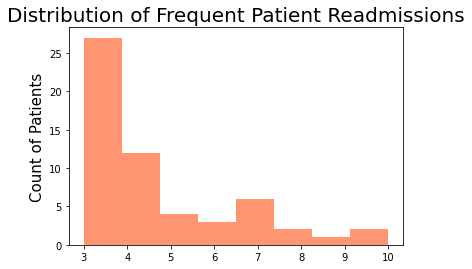

In [17]:
#filter for number of readmissions per patient
occurance1 = read_count_patient_high
bin1 = 8
title1= 'Distribution of Frequent Patient Readmissions'
x1='Count of Readmissions'
y1='Count of Patients'
#filter for number of readmissions per Hospital
occurance2 = read_count_hospital_high
bin2 = 7
title2= 'Distribution of Hospital Readmissions'
x2='Count of Readmissions'
y2='Count of Hospitals'
#save2 = frequentfliershospital
#filter for number of readmissions per Attendant 
occurance3 = read_count_attendant_high
bin3 = 5
title3= 'Distribution of Readmissions by Attendant'
x3='Count of Readmissions'
y3='Count of Attendants'
#filter for number of readmissions per Attendant 
occurance4 = read_count_month_high
bin4 = 12
title4= 'Distribution of variable'
x4='Count of Readmissions'
y4='Count of High Ocurrances'
#filter for number of readmissions per patient
occurance5 = combo
bin1 = 8
title5= 'Distribution of Frequent hospital Readmissions'
x5='rate'
y5='Count of read'

#plt.style.use('seaborn-pastel')
_= plt.hist('Encounter ID', bins = bin1, data = occurance1, color=['#ff9671'])
_= plt.title(title1, color = 'black', fontsize=20)
_= plt.ylabel(y1, fontsize=15)
#_= plt.xlabel(x2, fontsize=15)
plt.savefig('../imgs/frequentfliers', transparent = True)
#plt.style.available

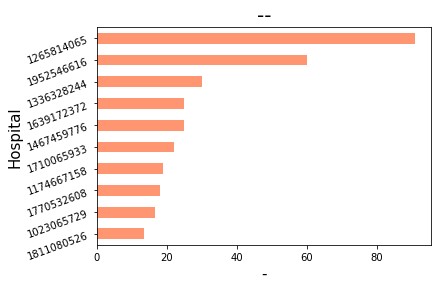

In [18]:
_=ax = combo4.plot.barh(x='Facility Provider NPI', y= 'rate', rot=20,legend=False,color=['#ff9671'])
_=plt.title("--", fontsize = 20)
_=plt.xlabel("-", fontsize = 15)
_=plt.ylabel("Hospital", fontsize = 15)

plt.savefig('../imgs/frequentfliers', transparent = True)
c = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
c

In [19]:
mean = occurance4['Encounter ID'].mean()

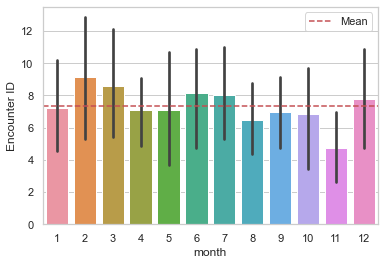

In [20]:
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(x='month', y='Encounter ID',  data=occurance4)
ax1.axhline(mean, color='r', linestyle='--', label="Mean")
_=ax1.legend()

LINE CHARTS

<ipython-input-21-271213b2a785>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  read_count_attendant_high['Attending Provider NPI']= read_count_attendant_high['Attending Provider NPI'].astype(str)


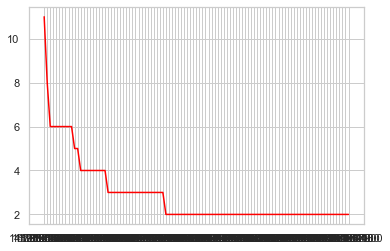

In [21]:
#filter for number of readmissions per patient
measure1 = read_count_patient_high['Patient ID']
value1 = read_count_patient_high['Encounter ID']
#filter for number of readmissions per Hospital
measure2 = read_count_hospital_high['Facility Provider NPI']
value2 =  read_count_hospital_high['Encounter ID']
#filter for number of readmissions per Attendant 
read_count_attendant_high['Attending Provider NPI']= read_count_attendant_high['Attending Provider NPI'].astype(str)
measure3 = read_count_attendant_high['Attending Provider NPI']
value3 = read_count_attendant_high['Encounter ID']

#ax = plt.gca()
#rc={'figure.figsize':(20,8.27)}
_=plt.plot(measure3, value3, color = 'red')

#_=plt.legend(title='title', bbox_to_anchor=(1, 1), loc='upper left')


PAIR PLOT

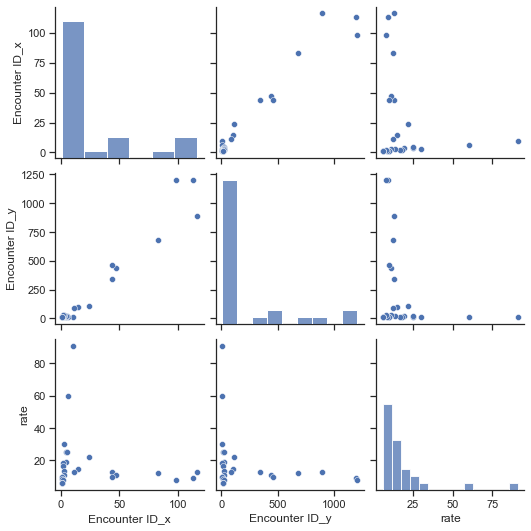

In [22]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(combo);

VIOLIN PLOT

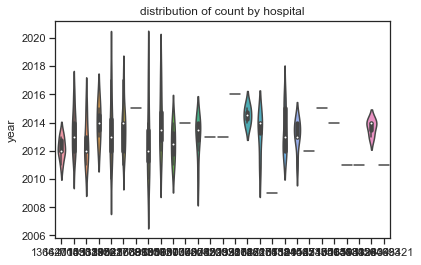

In [23]:
#sns.set(rc={'figure.figsize':(20,8.27)})
#violin = one_top[one_top['Facility Provider NPI'] == '1174667158']
violin = one_top[one_top['Days Since Last Visit'] == '0 Days']
sns.violinplot(y=violin['year'], x = violin['Facility Provider NPI'])
plt.title('distribution of count by hospital')
plt.xlabel('');

# MVP 2
What percent of patients have a PCP visit within a week of discharge?

# Variables and DFs
two - adm and pcp merged <br>
two_top - where pcp visits were within 7 days of leaving hospital<br>
count_two_top - <br>
pcp_visit_rate - rate of 7 day pcp visit out of all admissions<br>
pcp_count_patient - pcp grouped by patient and counted<br>
pcp_count_patient_high - where count is more than _<br>

In [24]:
two = adm.merge(pcp, left_on ='Patient ID', right_on = 'Patient ID',how='left', indicator = False)
#sub encounter date from end dates
two['Days Since Last Visit'] = two['Encounter Date'] - two['Encounter End Date']
two_top = two[two['Days Since Last Visit'] <= '7 days']
two_top = two_top[two_top['Days Since Last Visit'] >= '0 days']
two_top = two_top.sort_values(['Patient ID'], ascending = (False)).drop_duplicates(['Patient ID','Encounter End Date'])
#count
count_two_top = len(two_top)
pcp.head(2)

,Encounter ID,Patient ID,Service Provider ID,Attending Provider ID,Provider Group Provider ID,Facility Provider ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Attending Provider NPI,Facility Provider NPI,Service Provider NPI,Provider Group NPI,Encounter Date,Is Qualifying Preventive Primary Care Service,Is Qualifying Primary Care Service Provider,Is Qualifying Primary Care Attending,Is Qualifying Primary Care Provider Group,Qualifying Preventive Primary Care HCPCS Code
0,COV|EE|DS1|10076|20110225|DS1|NPI|1487856779,DS1|10076,DS1|NPI|1487856779,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.487857e+09,1.043427e+09,2011-02-18,0,1,0,0,NaN
1,COV|EE|DS1|10088|20140222|DS1|NPI|1528030996,DS1|10088,DS1|NPI|1528030996,DS1|NPI|1528030996,DS1|NPI|1043427248,DS1|NPI|1902803315,DS1|1,DS1|5047W,1.528031e+09,1.902803e+09,1.528031e+09,1.043427e+09,2014-02-22,0,1,1,1,NaN


In [25]:
#find the pcp visit within 7 days rate
pcp_visit_rate = round(count_two_top/adm_count *100,2)
pcp_visit_rate

29.99

In [26]:
#filter for number of readmissions per hospital
pcp_count_patient = two_top.groupby(['Facility Provider NPI_x'], as_index=False).count()
pcp_count_patient = pcp_count_patient.sort_values(['Encounter ID_x'], ascending = (False))
pcp_count_patient_high =pcp_count_patient[pcp_count_patient['Encounter ID_x'] >= 5]

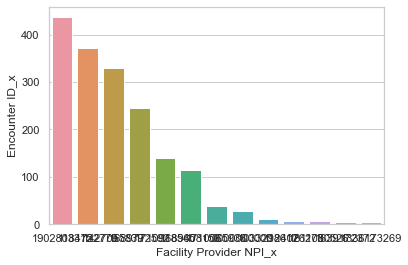

In [27]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Facility Provider NPI_x', y='Encounter ID_x',  data=pcp_count_patient_high)

# Did those who went to their PCP go back to the hospital?

In [28]:
two_top['Previous End Date'] = (one.groupby('Patient ID')['Encounter End Date'].shift(1))
two_top['Previous End Date'] = pd.to_datetime(two_top['Previous End Date'], format='%Y-%m-%d')
#one['Days Since Last Visit'] = one['Encounter Start Date'] - one['Previous End Date']
two_top


,Encounter ID_x,Patient ID,Encounter Primary Payor ID_x,Encounter Primary Plan ID_x,Facility Provider ID_x,Attending Provider ID_x,Attending Provider NPI_x,Facility Provider NPI_x,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Encounter ID_y,Service Provider ID,Attending Provider ID_y,Provider Group Provider ID,Facility Provider ID_y,Encounter Primary Payor ID_y,Encounter Primary Plan ID_y,Attending Provider NPI_y,Facility Provider NPI_y,Service Provider NPI,Provider Group NPI,Encounter Date,Is Qualifying Preventive Primary Care Service,Is Qualifying Primary Care Service Provider,Is Qualifying Primary Care Attending,Is Qualifying Primary Care Provider Group,Qualifying Preventive Primary Care HCPCS Code,Days Since Last Visit,Previous End Date
44077,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,DS1|1,DS1|5047W,DS1|NPI|1427055839,DS1|NPI|1215968474,1.215968e+09,1427055839,2014-08-07,2014-08-10,0,1,3.0,1,1,21.0,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,0,14800.00,250.0,COV|PCSL|DS1|9981|P|271104|1043427248|1,DS1|NPI|1992932388,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.992932e+09,1.043427e+09,2014-08-12,0.0,1.0,0.0,0.0,NaN,2 days,NaT
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,DS1|1,DS1|5047X,DS1|NPI|1689772592,DS1|NPI|1720043417,1.720043e+09,1689772592,2015-02-06,2015-02-11,0,0,2.0,2,6,21.0,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",0,23598.00,250.0,COV|PCSL|DS1|9979|P|281365|1477666352|1,DS1|NPI|1740277995,NaN,DS1|NPI|1477666352,NaN,DS1|1,DS1|5047X,NaN,NaN,1.740278e+09,1.477666e+09,2015-02-15,0.0,1.0,0.0,0.0,NaN,4 days,NaT
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,DS1|9978,DS1|1,DS1|5047X,DS1|NPI|1427055839,DS1|NPI|1316989247,1.316989e+09,1427055839,2015-09-01,2015-09-05,1,0,1.0,1,1,23.0,532.50,Chronic or unspecified duodenal ulcer with per...,NaN,NaN,0,22217.80,250.0,COV|PCSL|DS1|9978|P|696226|1043427248|1,DS1|NPI|1144274911,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047X,NaN,NaN,1.144275e+09,1.043427e+09,2015-09-11,0.0,1.0,0.0,0.0,NaN,6 days,NaT
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,DS1|9945,DS1|1,DS1|5047W,DS1|NPI|1902803315,DS1|NPI|1104144120,1.104144e+09,1902803315,2013-02-09,2013-02-11,0,1,3.0,1,1,21.0,NaN,NaN,O48.0,Post-term pregnancy,0,9350.00,250.0,COV|PCSL|DS1|9945|P|840374|1043427248|1,DS1|NPI|1164698098,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.164698e+09,1.043427e+09,2013-02-14,1.0,1.0,0.0,0.0,99381,3 days,NaT
44039,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,DS1|1,DS1|5047X,DS1|NPI|1184722779,DS1|NPI|1265649966,1.265650e+09,1184722779,2014-10-28,2014-10-30,0,0,3.0,1,1,21.0,NaN,NaN,K43.0,"Incisional hernia with obstruction, without ga...",0,20869.25,500.0,COV|PCSL|DS1|9943|P|1315984|1184722779|1,DS1|NPI|1659329837,NaN,DS1|NPI|1184722779,NaN,DS1|1,DS1|5047X,NaN,NaN,1.659330e+09,1.184723e+09,2014-11-03,0.0,1.0,0.0,0.0,NaN,4 days,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,HIA|DS1|10305|DS1|NPI|1184722779|1,DS1|10305,DS1|1,DS1|5047W,DS1|NPI|1184722779,DS1|NPI|1730127069,1.730127e+09,1184722779,2014-05-10,2014-05-12,0,0,2.0,1,1,21.0,654.21,"Previous cesarean delivery, delivered, with or...",NaN,NaN,0,7650.00,250.0,COV|PBSL|DS1|10305|P|823298|1184722779|1,DS1|NPI|1417113168,NaN,DS1|NPI|1184722779,NaN,DS1|1,DS1|5047W,NaN,NaN,1.417113e+09,1.184723e+09,2014-05-13,1.0,1.0,0.0,0.0,99381,1 days,NaT
238,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,DS1|1,DS1|5047W,DS1|NPI|1710918545,DS1|NPI|1508

# Question 3
Do either vary by individual or group PCP's?